# Flower Classification using MobileNetV2 on the Oxford Flowers 102 Dataset

In [ ]:
# necessary imports
import json
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_hub as hub
from PIL import Image
import pickle

In [ ]:
# Here i defined the batch and image size i will use to build the dataset
IMG_RES = 224
BATCH_SIZE = 32

## Build and explore the datasets

In [ ]:
# download the Oxford Flowers 102 dataset from tensorflow datasets
# The dataset by default comes with a test size larger than the train size. For more info see this issue : https://github.com/tensorflow/datasets/issues/3022.
# So here i will use the default test set as the training set as it contains more data.
(training_data, test_data , validation_data), data_infos = tfds.load('oxford_flowers102',split=['test', 'train','validation'],
                                                shuffle_files=True,
                                                as_supervised= True,
                                                with_info=True,)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete708HBR/oxford_flowers102-test.tfrecord*.…

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete708HBR/oxford_flowers102-validation.tfre…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [ ]:
# Here i'm printing out the number of samples i have for each set (training, validation and test) and the number of labels
print("Total number of training samples :", len(training_data))
print("Total number of test samples :", len(test_data))
print("Total number of validation samples :", len(validation_data))

num_classes = data_infos.features['label'].num_classes
print("Total number of classes  :", num_classes)


Total number of training samples : 6149
Total number of test samples : 1020
Total number of validation samples : 1020
Total number of classes  : 102


In [ ]:
# Here i take 3 samples on the training data and print out their shape and label
for i , sample in enumerate(training_data.take(3)):
  print("Image {} shape {} label {}".format(i+1, sample[0].shape, sample[1]))

Image 1 shape (542, 500, 3) label 40
Image 2 shape (748, 500, 3) label 76
Image 3 shape (500, 600, 3) label 42


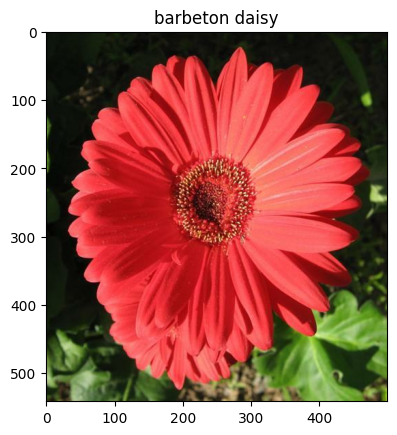

In [ ]:
# Here i  take a sample on the training data and get his label with the int2str mathod and plot it
get_label_name = data_infos.features['label'].int2str

for image, label in training_data.take(1):
    plt.imshow(image)
    plt.title(get_label_name(label))
    plt.show()

In [ ]:
# Here i wrote the functions to build the dataset

# the normalize_img function will resize the images to the IMG_RES defined earlier,
# convert them to tensorflow float32 and normalize their content and then return the images and the label
def normalize_img(image, label, img_size=IMG_RES):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (img_size, img_size))
    return tf.cast(image, tf.float32) / 255., label

# the build_dataset function will take the previously downloaded Dataset and it's infos , the set to process and the batch size
''' def build_dataset(dataset, infos = data_infos, which='train', batch_size = BATCH_SIZE):
    dataset = dataset.map(normalize_img, num_parallel_calls = tf.data.AUTOTUNE)
    if which == 'test':
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(1)
        return dataset
    dataset = dataset.cache()
    if which == 'train':
      dataset = dataset.shuffle(len(training_data)//4)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(1)
    return dataset '''

def build_dataset(data, data_infos=data_infos, batch_size=BATCH_SIZE, shuffle=False):
  dataset = data.map(normalize_img, num_parallel_calls = tf.data.AUTOTUNE)
  dataset = dataset.cache()
  if shuffle:
    dataset = dataset.shuffle(len(data)//4)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(1)
  return dataset

In [ ]:
# Here i'm building the three set we will need for training, testing and validation
train_ds = build_dataset(training_data, shuffle=True)
validation_ds = build_dataset(validation_data)
test_ds = build_dataset(test_data)

## Build the model

In [ ]:
# bulding a feature extractor with mobilenet_v2
# previous versions of this notebook used Resnet, EfficientNet, InceptionV3 and custom CNN
# i keep mobilenet_V2 as it gives the highest accuracy

URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,input_shape=(IMG_RES, IMG_RES, 3))

feature_extractor.trainable = False

In [ ]:
# writting a data augmentation layer to reduce overfitting
data_augmentation = keras.Sequential(
[
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1)
])


In [ ]:
# adding classification head

classifier = keras.Sequential([
    layers.Flatten(),
    layers.Dense(1024, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation="softmax")
], name="head_classifier")

In [ ]:
# Putting it all together to build the model

inputs = keras.Input(shape=(IMG_RES, IMG_RES, 3))
x = data_augmentation(inputs)
x = feature_extractor(x, training=False)
outputs = classifier(x)

model = keras.Model(inputs , outputs , name="mobilenet_v2_keras")

In [ ]:
# Compiling the model with Adam as optimizer and SparseCategoricalCrossentropy as loss
# The metric will be the accuracy

base_learning_rate = 1e-4
optimizer = keras.optimizers.Adam(learning_rate= base_learning_rate)
loss = keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer = optimizer,
              loss= loss ,
              metrics = ["accuracy"]
)

model.summary()

Model: "mobilenet_v2_keras"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 head_classifier (Sequential  (None, 102)              1416294   
 )                                                               
                                                                 
Total params: 3,674,278
Trainable params: 1,416,294
Non-trainable params: 2,257,984
_________________________________________________________________


## Compile and Train the model

In [ ]:
# Here i added two callbacks, a model checkpoint to save the best model
# and an early stopping to stop the training before overfitting

ModelCheckpoint = keras.callbacks.ModelCheckpoint(
    filepath = "{}.keras".format(model.name),
    save_best_only = True
)

EarlyStopping = keras.callbacks.EarlyStopping(
    patience = 5,
    restore_best_weights = True
)

In [ ]:
# Evaluating the non trained model to have some initial metrics
initial_epoch = 20
loss0 , accuracy0 = model.evaluate(validation_ds)

print("Initial Loss : {}".format(loss0))
print("Initial Accuracy : {}".format(accuracy0))

32/32 [==============================] - 11s 118ms/step - loss: 4.8438 - accuracy: 0.0088
Initial Loss : 4.843822002410889
Initial Accuracy : 0.008823529817163944


In [ ]:
# Started Training the model

# Clear the backend to Resets all state generated by Keras.
tf.keras.backend.clear_session()
history = model.fit( train_ds,
                    validation_data = validation_ds ,
                    epochs = initial_epoch+20 ,
                    callbacks = [ModelCheckpoint, EarlyStopping])

Epoch 1/40
193/193 [==============================] - 31s 120ms/step - loss: 3.6184 - accuracy: 0.2332 - val_loss: 3.2427 - val_accuracy: 0.2569
Epoch 2/40
193/193 [==============================] - 13s 68ms/step - loss: 2.2233 - accuracy: 0.4954 - val_loss: 2.1804 - val_accuracy: 0.5020
Epoch 3/40
193/193 [==============================] - 12s 60ms/step - loss: 1.5638 - accuracy: 0.6224 - val_loss: 1.6400 - val_accuracy: 0.6431
Epoch 4/40
193/193 [==============================] - 11s 57ms/step - loss: 1.2431 - accuracy: 0.6816 - val_loss: 1.3162 - val_accuracy: 0.6873
Epoch 5/40
193/193 [==============================] - 12s 61ms/step - loss: 1.0499 - accuracy: 0.7375 - val_loss: 1.1482 - val_accuracy: 0.7314
Epoch 6/40
193/193 [==============================] - 11s 58ms/step - loss: 0.9289 - accuracy: 0.7601 - val_loss: 1.0283 - val_accuracy: 0.7441
Epoch 7/40
193/193 [==============================] - 11s 56ms/step - loss: 0.8305 - accuracy: 0.7871 - val_loss: 0.9499 - val_accuracy

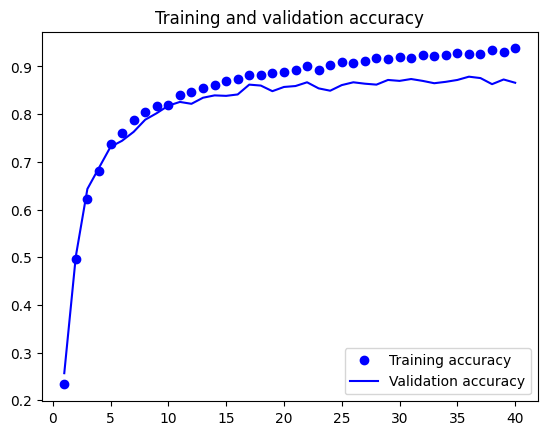

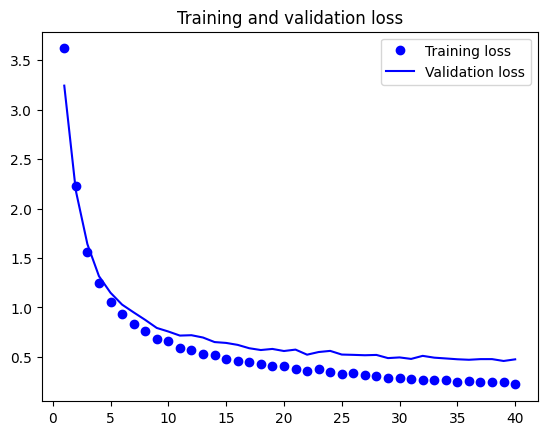

In [ ]:
# Here i plot the model's training history

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
# load the best saved model and evaluate it on the test dataset
path = "{}.keras".format(model.name)
model = keras.models.load_model(path,  custom_objects={'KerasLayer': hub.KerasLayer})
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 79ms/step - loss: 0.5364 - accuracy: 0.8422
Test accuracy: 0.842


## export the model


In [ ]:
config_path = "model_config.json"
weights_path = "model_weights.h5"
label_name_path = "label_name_dict.pickle"

In [ ]:
## get a dictionary of the labels
label_name_dict = {}
for i in range(102):
  label_name_dict[i] = get_label_name(i)

label_name_dict[0]

'pink primrose'

In [ ]:
# Serialize the dictionary using pickle
with open(label_name_path, 'wb') as f:
    pickle.dump(label_name_dict, f)

In [ ]:
# get the model's config in a json file and save it

model_config = model.to_json()
with open(config_path,"w") as file :
  file.write(model_config)


In [ ]:
# export the weights

model.save_weights(save_format="h5", filepath=weights_path)

In [ ]:
## download the model config, weights and labels dictionary from google colab
from google.colab import files
files.download(config_path)
files.download(weights_path)
files.download(label_name_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>